In [1]:
import numpy as np
import pandas as pd

import os
import math
import time

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.figure_factory as ff
import plotly.graph_objects as go
import plotly.express as px

# Below libraries are for text processing using NLTK
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Below libraries are for feature representation using sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Below libraries are for similarity matrices using sklearn
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import pairwise_distances

In [ ]:
# news_articles = pd.read_json("/kaggle/input/news-category-dataset-v2/News_Category_Dataset_v2.json", lines = True)

In [2]:
news_articles = pd.read_json("News_Category_Dataset_v3.json", lines = True)

In [3]:
news_articles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209527 entries, 0 to 209526
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   link               209527 non-null  object        
 1   headline           209527 non-null  object        
 2   category           209527 non-null  object        
 3   short_description  209527 non-null  object        
 4   authors            209527 non-null  object        
 5   date               209527 non-null  datetime64[ns]
dtypes: datetime64[ns](1), object(5)
memory usage: 9.6+ MB


In [5]:
news_articles.head()

,link,headline,category,short_description,authors,date
0,https://www.huffpost.com/entry/covid-boosters-...,Over 4 Million Americans Roll Up Sleeves For O...,U.S. NEWS,Health experts said it is too early to predict...,"Carla K. Johnson, AP",2022-09-23
1,https://www.huffpost.com/entry/american-airlin...,"American Airlines Flyer Charged, Banned For Li...",U.S. NEWS,He was subdued by passengers and crew when he ...,Mary Papenfuss,2022-09-23
2,https://www.huffpost.com/entry/funniest-tweets...,23 Of The Funniest Tweets About Cats And Dogs ...,COMEDY,"""Until you have a dog you don't understand wha...",Elyse Wanshel,2022-09-23
3,https://www.huffpost.com/entry/funniest-parent...,The Funniest Tweets From Parents This Week (Se...,PARENTING,"""Accidentally put grown-up toothpaste on my to...",Caroline Bologna,2022-09-23
4,https://www.huffpost.com/entry/amy-cooper-lose...,Woman Who Called Cops On Black Bird-Watcher Lo...,U.S. NEWS,Amy Cooper accused investment firm Franklin Te...,Nina Golgowski,2022-09-22


In [6]:
news_articles = news_articles[news_articles['date'] >= pd.Timestamp(2018,1,1)]

In [7]:
news_articles.shape

(17257, 6)

In [8]:
news_articles = news_articles[news_articles['headline'].apply(lambda x: len(x.split())>5)]
print("Total number of articles after removal of headlines with short title:", news_articles.shape[0])

Total number of articles after removal of headlines with short title: 17183


In [9]:
news_articles.sort_values('headline',inplace=True, ascending=False)
duplicated_articles_series = news_articles.duplicated('headline', keep = False)
news_articles = news_articles[~duplicated_articles_series]
print("Total number of articles after removing duplicates:", news_articles.shape[0])

Total number of articles after removing duplicates: 17113


In [10]:
news_articles.isna().sum()

,0
link,0
headline,0
category,0
short_description,0
authors,0
date,0


In [11]:
print("Total number of articles : ", news_articles.shape[0])
print("Total number of authors : ", news_articles["authors"].nunique())
print("Total number of unqiue categories : ", news_articles["category"].nunique())

Total number of articles :  17113
Total number of authors :  2256
Total number of unqiue categories :  36


In [12]:
fig = go.Figure([go.Bar(x=news_articles["category"].value_counts().index, y=news_articles["category"].value_counts().values)])
fig['layout'].update(title={"text" : 'Distribution of articles category-wise','y':0.9,'x':0.5,'xanchor': 'center','yanchor': 'top'}, xaxis_title="Category name",yaxis_title="Number of articles")
fig.update_layout(width=800,height=700)
fig

In [13]:
news_articles_per_month = news_articles.resample('m',on = 'date')['headline'].count()
news_articles_per_month
# # 'm' is deprecated and will be removed in a future version, please use 'ME' instead.

<ipython-input-13-f6eb388702b7>:1: FutureWarning:

'm' is deprecated and will be removed in a future version, please use 'ME' instead.



,headline
date,
2018-01-31,2065
2018-02-28,1694
2018-03-31,1778
2018-04-30,1580
2018-05-31,1391
2018-06-30,136
2018-07-31,155
2018-08-31,123
2018-09-30,156


In [14]:
# news_articles_per_month = news_articles.resample('ME',on = 'date')['headline'].count()
# news_articles_per_month

In [15]:
fig = go.Figure([go.Bar(x=news_articles_per_month.index.strftime("%b"), y=news_articles_per_month)])
fig['layout'].update(title={"text" : 'Distribution of articles month-wise','y':0.9,'x':0.5,'xanchor': 'center','yanchor': 'top'}, xaxis_title="Month",yaxis_title="Number of articles")
fig.update_layout(width=500,height=500)
fig

In [16]:
fig = ff.create_distplot([news_articles['headline'].str.len()], ["ht"],show_hist=False,show_rug=False)
fig['layout'].update(title={'text':'PDF','y':0.9,'x':0.5,'xanchor': 'center','yanchor': 'top'}, xaxis_title="Length of a headline",yaxis_title="probability")
fig.update_layout(showlegend = False,width=500,height=500)
fig

In [17]:
news_articles.index = range(news_articles.shape[0])

In [18]:
# Adding a new column containing both day of the week and month, it will be required later while recommending based on day of the week and month
news_articles["day and month"] = news_articles["date"].dt.strftime("%a") + "_" + news_articles["date"].dt.strftime("%b")

In [19]:
news_articles_temp = news_articles.copy()

In [20]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [21]:
stop_words = set(stopwords.words('english'))

In [22]:
for i in range(len(news_articles_temp["headline"])):
    string = ""
    for word in news_articles_temp["headline"][i].split():
        word = ("".join(e for e in word if e.isalnum()))
        word = word.lower()
        if not word in stop_words:
          string += word + " "
    if(i%1000==0):
      print(i)           # To track number of records processed
    news_articles_temp.at[i,"headline"] = string.strip()

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000


In [23]:
lemmatizer = WordNetLemmatizer()

In [27]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [28]:
for i in range(len(news_articles_temp["headline"])):
    string = ""
    for w in word_tokenize(news_articles_temp["headline"][i]):
        string += lemmatizer.lemmatize(w,pos = "v") + " "
    news_articles_temp.at[i, "headline"] = string.strip()
    if(i%1000==0):
        print(i)           # To track number of records processed

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000


In [29]:
headline_vectorizer = CountVectorizer()
headline_features   = headline_vectorizer.fit_transform(news_articles_temp['headline'])

In [30]:
headline_features.get_shape()


(17113, 16522)

In [31]:
pd.set_option('display.max_colwidth', None)  # To display a very long headline completely

In [32]:
def bag_of_words_based_model(row_index, num_similar_items):
    couple_dist = pairwise_distances(headline_features,headline_features[row_index])
    indices = np.argsort(couple_dist.ravel())[0:num_similar_items]
    df = pd.DataFrame({'publish_date': news_articles['date'][indices].values,
               'headline':news_articles['headline'][indices].values,
                'Euclidean similarity with the queried article': couple_dist[indices].ravel()})
    print("="*30,"Queried article details","="*30)
    print('headline : ',news_articles['headline'][indices[0]])
    print("\n","="*25,"Recommended articles : ","="*23)
    #return df.iloc[1:,1]
    return df.iloc[1:,]

bag_of_words_based_model(133, 11) # Change the row index for any other queried article

============================== Queried article details ==============================
headline :  Yovanovitch Responds To Trump Twitter Attacks In Real Time In Dramatic Impeachment Testimony

 ========================= Recommended articles :  =======================


,publish_date,headline,Euclidean similarity with the queried article
1,2019-11-15,Twitter Users Smack Down Trump's Attack On Marie Yovanovitch,3.000000
2,2022-05-17,Donald Trump Is Back On Twitter,3.162278
3,2019-10-22,Trump Likens Impeachment Inquiry To 'A Lynching' In Twitter Outburst,3.316625
4,2019-11-16,Pelosi On Trump's Yovanovitch Attack: He Knows He's In Over His Head,3.316625
5,2018-01-20,How The LA Times Union Won,3.316625
6,2019-09-26,Here Are The Democratic Impeachment Holdouts,3.316625
7,2018-04-27,Donald Trump And The Next Crash,3.464102
8,2019-01-29,Who Congress Follows On Twitter — Exposed!,3.464102
9,2018-03-09,'A Wrinkle In Time' And The Burden Of Being First,3.464102
10,2018-02-02,The Real Purpose Of The Nunes Memo,3.464102


In [33]:
tfidf_headline_vectorizer = TfidfVectorizer(min_df = 1)
tfidf_headline_features = tfidf_headline_vectorizer.fit_transform(news_articles_temp['headline'])

In [34]:
def tfidf_based_model(row_index, num_similar_items):
    couple_dist = pairwise_distances(tfidf_headline_features,tfidf_headline_features[row_index])
    indices = np.argsort(couple_dist.ravel())[0:num_similar_items]
    df = pd.DataFrame({'publish_date': news_articles['date'][indices].values,
               'headline':news_articles['headline'][indices].values,
                'Euclidean similarity with the queried article': couple_dist[indices].ravel()})
    print("="*30,"Queried article details","="*30)
    print('headline : ',news_articles['headline'][indices[0]])
    print("\n","="*25,"Recommended articles : ","="*23)

    #return df.iloc[1:,1]
    return df.iloc[1:,]
tfidf_based_model(133, 11)

============================== Queried article details ==============================
headline :  Yovanovitch Responds To Trump Twitter Attacks In Real Time In Dramatic Impeachment Testimony

 ========================= Recommended articles :  =======================


,publish_date,headline,Euclidean similarity with the queried article
1,2019-11-15,Twitter Users Smack Down Trump's Attack On Marie Yovanovitch,1.116687
2,2019-11-16,Pelosi On Trump's Yovanovitch Attack: He Knows He's In Over His Head,1.138892
3,2018-09-27,"Conservatives, Right-Wing Media Respond To Christine Blasey Ford's Testimony",1.241658
4,2018-01-03,"Trump Jokes About 'Fake' Media Awards, But Twitter Was The Real Winner",1.253860
5,2021-07-21,Dramatic Videos Show Deadly Flooding In China,1.265026
6,2019-10-22,Trump Likens Impeachment Inquiry To 'A Lynching' In Twitter Outburst,1.269819
7,2022-05-17,Donald Trump Is Back On Twitter,1.278591
8,2018-02-14,Donald Trump Jr. Attacks Olympian Adam Rippon On Twitter,1.282941
9,2019-10-15,Trump Appears To Call For His Own Impeachment In Bizarre Tweet,1.286440
10,2021-01-25,"Lawmakers Face Threat Of Second Capitol Attack Ahead Of Impeachment, AP Reports",1.290482


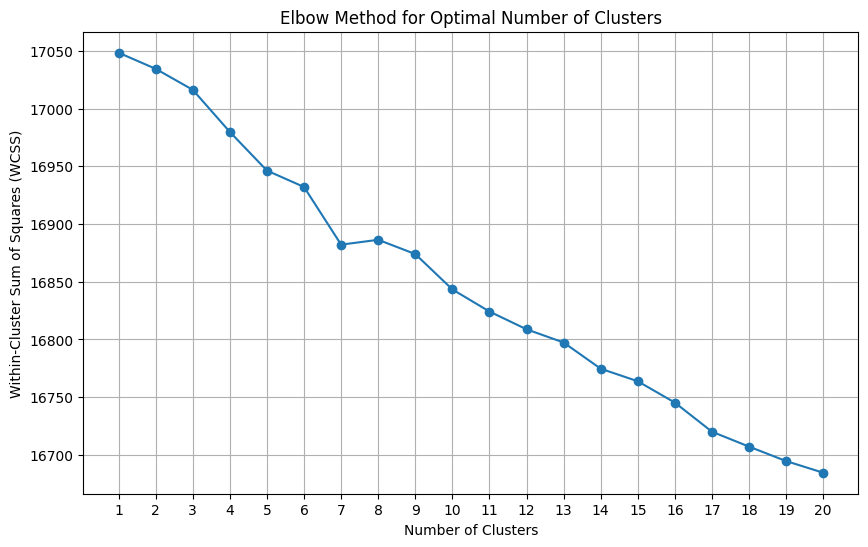

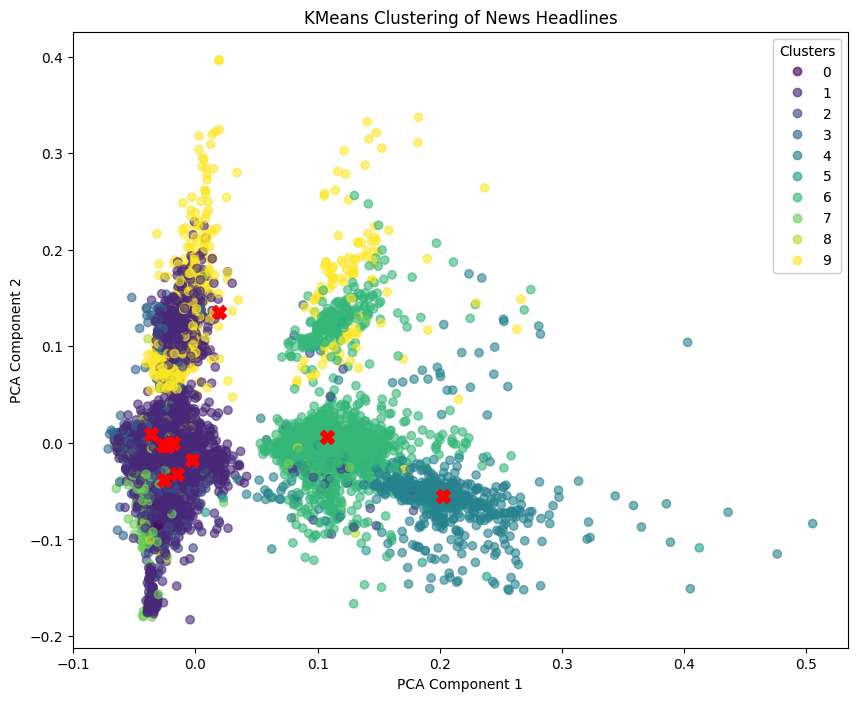


Cluster 0:
 - rise leslie kick kit harington house super relatable reason
 - worlds dangerous bird kill 75yearold owner florida
 - worlds best food cities accord tripadvisor
 - richard branson want build highspeed hyperloop india
 - theres pawsome news worlds worst cat

Cluster 1:
 - federal judge suspend new york citys vaccine mandate teachers
 - brazils jair bolsonaro farright authoritarian promise hed
 - susan collins say wouldnt hurt pass bill protect robert mueller
 - 4 years later 3 new miles wall single peso mexico
 - joe biden slap question fox news peter doocy get silly

Cluster 2:
 - rachel maddow read damn giuliani testimony show root election conspiracy
 - join drag queen tv show cost indiana pastor job
 - snl perfectly parody draw barrymore show dig ellen
 - tomi lahren mock rightwing crisis actor daily show conspiracy spoof
 - heres video trump try explain cut pandemic response team

Cluster 3:
 - florida gunman full body armor arrest kill 4 police
 - stray bullet kill p

In [35]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Determine the optimal number of clusters using the elbow method
wcss = []
cluster_range = range(1, 21)  # Test from 1 to 20 clusters

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(tfidf_headline_features)
    wcss.append(kmeans.inertia_)

# Plotting the elbow plot
plt.figure(figsize=(10, 6))
plt.plot(cluster_range, wcss, marker='o')
plt.xlabel("Number of Clusters")
plt.ylabel("Within-Cluster Sum of Squares (WCSS)")
plt.title("Elbow Method for Optimal Number of Clusters")
plt.xticks(cluster_range)
plt.grid(True)
plt.show()

# Step 2: Set the optimal number of clusters based on the elbow plot
optimal_clusters = 10  # Choose based on the elbow plot

# Fit KMeans on the TF-IDF features with the optimal number of clusters
kmeans_model = KMeans(n_clusters=optimal_clusters, random_state=42)
kmeans_model.fit(tfidf_headline_features)
clusters = kmeans_model.labels_

# Add cluster labels to the DataFrame
news_articles_temp['Cluster'] = clusters

# Step 3: Visualizing clusters using PCA (dimensionality reduction to 2D for visualization)
pca = PCA(n_components=2, random_state=42)
reduced_features = pca.fit_transform(tfidf_headline_features.toarray())
reduced_cluster_centers = pca.transform(kmeans_model.cluster_centers_)

# Plotting the clusters
fig, ax = plt.subplots(figsize=(10, 8))
scatter = ax.scatter(reduced_features[:, 0], reduced_features[:, 1], c=clusters, cmap='viridis', alpha=0.6)
centers = ax.scatter(reduced_cluster_centers[:, 0], reduced_cluster_centers[:, 1], c='red', s=100, marker='X')
legend1 = ax.legend(*scatter.legend_elements(), title="Clusters")
ax.add_artist(legend1)
plt.title('KMeans Clustering of News Headlines')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

# Display a few articles from each cluster
for cluster_num in range(optimal_clusters):
    print(f"\nCluster {cluster_num}:")
    sample_articles = news_articles_temp[news_articles_temp['Cluster'] == cluster_num]['headline'].sample(5, random_state=42).values
    for article in sample_articles:
        print(f" - {article}")



Cluster 0:
 - rise leslie kick kit harington house super relatable reason
 - worlds dangerous bird kill 75yearold owner florida
 - worlds best food cities accord tripadvisor
 - richard branson want build highspeed hyperloop india
 - theres pawsome news worlds worst cat

Cluster 1:
 - federal judge suspend new york citys vaccine mandate teachers
 - brazils jair bolsonaro farright authoritarian promise hed
 - susan collins say wouldnt hurt pass bill protect robert mueller
 - 4 years later 3 new miles wall single peso mexico
 - joe biden slap question fox news peter doocy get silly

Cluster 2:
 - rachel maddow read damn giuliani testimony show root election conspiracy
 - join drag queen tv show cost indiana pastor job
 - snl perfectly parody draw barrymore show dig ellen
 - tomi lahren mock rightwing crisis actor daily show conspiracy spoof
 - heres video trump try explain cut pandemic response team

Cluster 3:
 - florida gunman full body armor arrest kill 4 police
 - stray bullet kill p

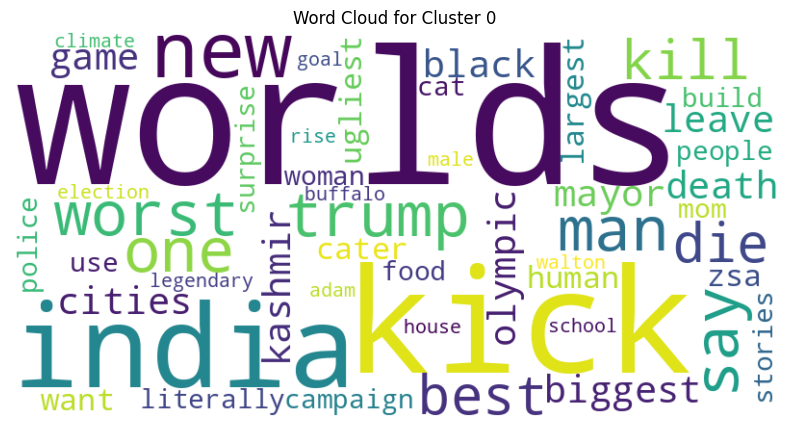

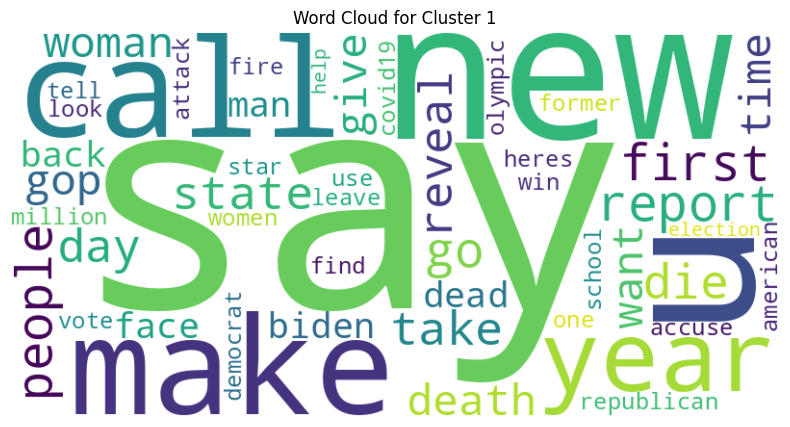

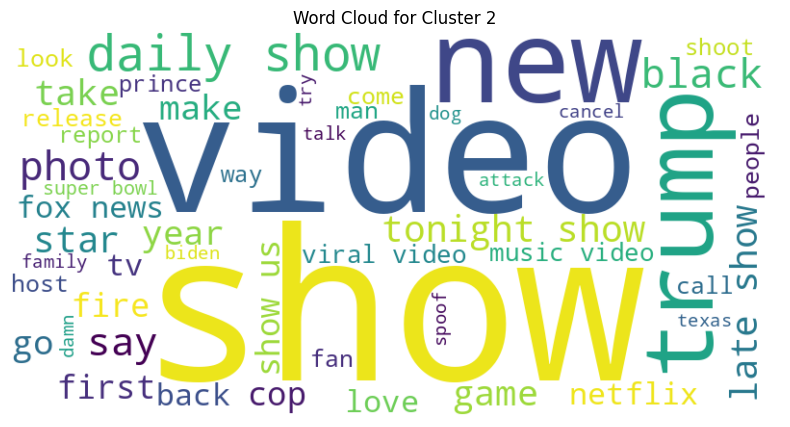

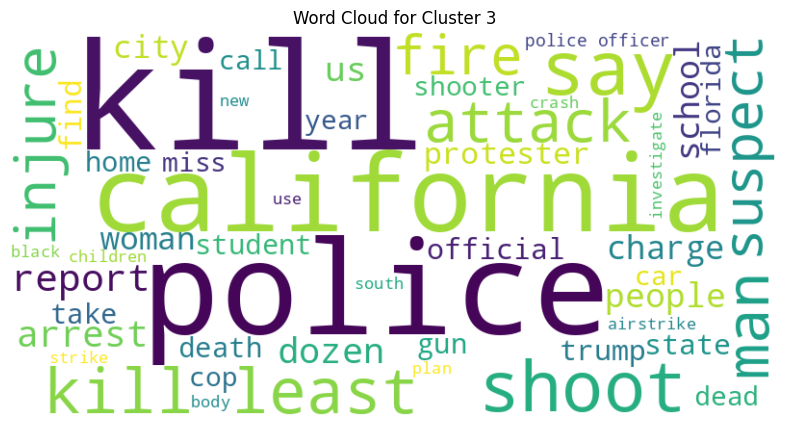

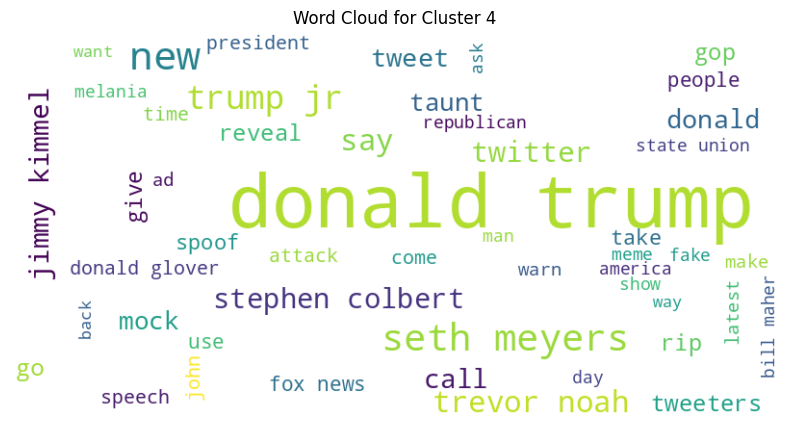

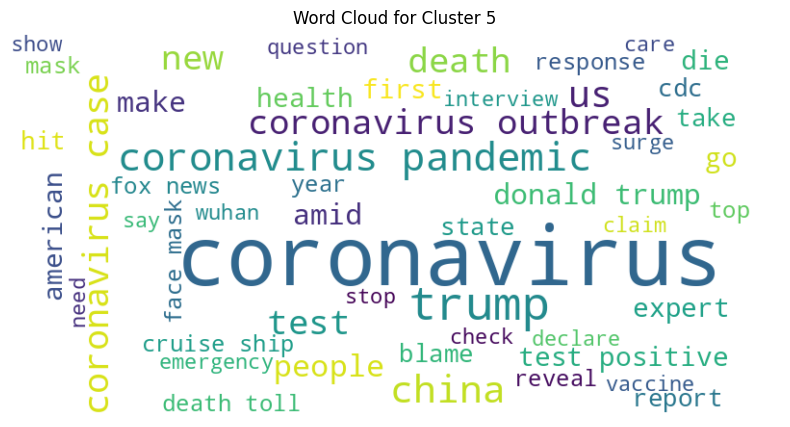

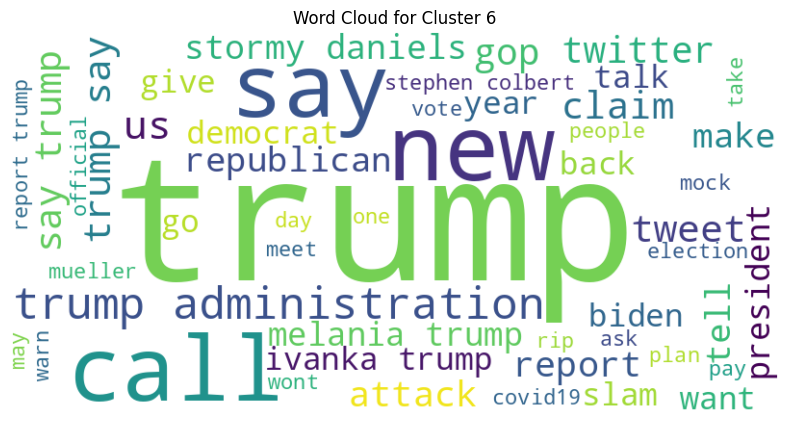

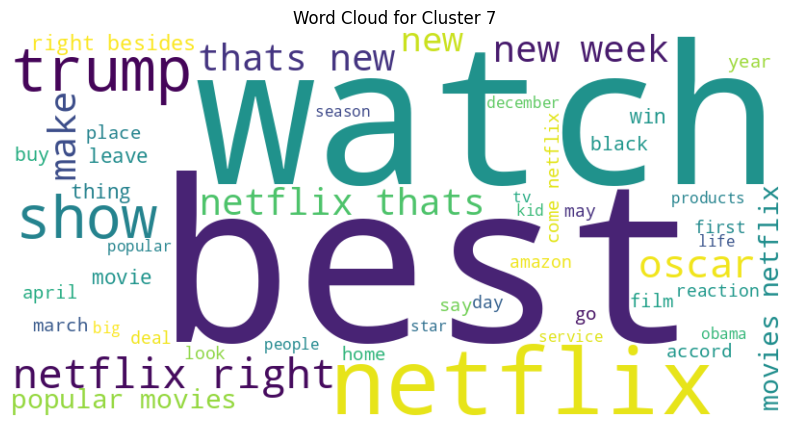

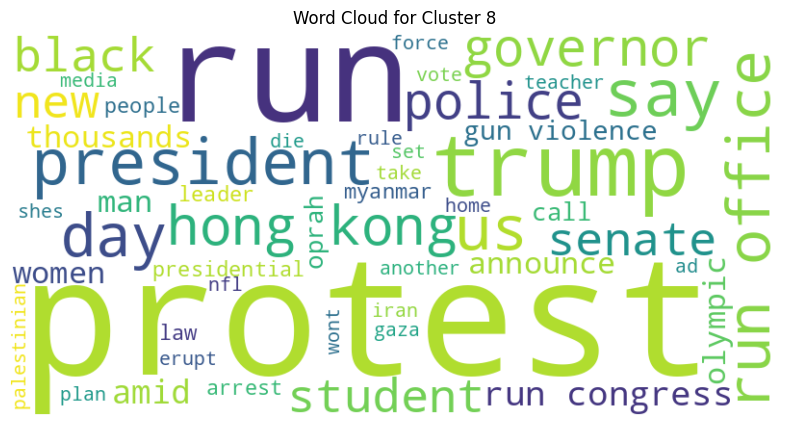

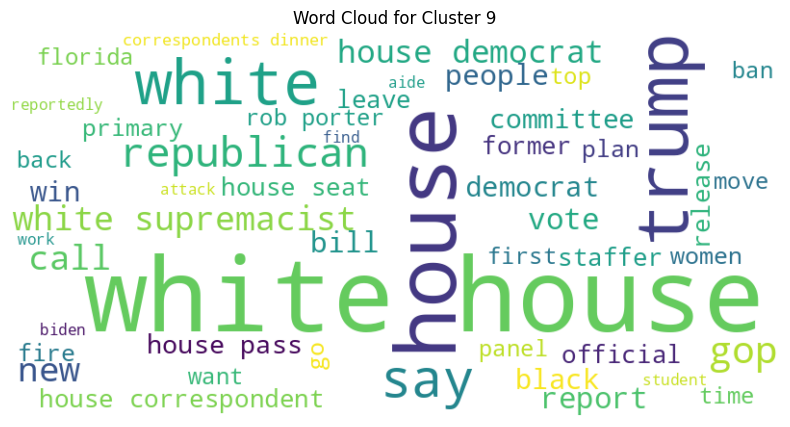

In [36]:
for cluster_num in range(optimal_clusters):
    print(f"\nCluster {cluster_num}:")
    sample_articles = news_articles_temp[news_articles_temp['Cluster'] == cluster_num]['headline'].sample(5, random_state=42).values
    for article in sample_articles:
        print(f" - {article}")

from collections import Counter
import re

# Function to get most common words in a cluster
def get_top_words(cluster_num, n_top_words=10):
    cluster_headlines = news_articles_temp[news_articles_temp['Cluster'] == cluster_num]['headline']
    words = ' '.join(cluster_headlines).lower()
    words = re.findall(r'\b\w+\b', words)
    common_words = Counter(words).most_common(n_top_words)
    return common_words

# Print top words in each cluster
for cluster_num in range(optimal_clusters):
    print(f"\nCluster {cluster_num} - Top Words:")
    print(get_top_words(cluster_num))

from wordcloud import WordCloud
import matplotlib.pyplot as plt

for cluster_num in range(optimal_clusters):
    cluster_text = ' '.join(news_articles_temp[news_articles_temp['Cluster'] == cluster_num]['headline'])
    wordcloud = WordCloud(width=800, height=400, max_words=50, background_color='white').generate(cluster_text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Word Cloud for Cluster {cluster_num}")
    plt.show()


In [37]:
# Define a dictionary that maps each cluster number to a descriptive theme
cluster_themes = {
    0: "Politics or International Relations",
    1: "Health and Wellness",
    2: "Entertainment and Celebrities",
    3: "Technology and Science",
    4: "Business and Economy",
    5: "Sports",
    6: "Environment and Climate",
    7: "Education",
    8: "Lifestyle and Culture",
    9: "Crime and Law"
}

# Map cluster numbers to theme labels
news_articles_temp['Theme'] = news_articles_temp['Cluster'].map(cluster_themes)

# Display a few rows to verify
print(news_articles_temp[['headline', 'Cluster', 'Theme']].head(10))

# Optionally, you could also print the count of articles per theme
print("\nNumber of articles per theme:")
print(news_articles_temp['Theme'].value_counts())


                                                                           headline  \
0                          n sync chris kirkpatrick say couldnt room backstreet boy   
1                                           19 kid count father run arkansas senate   
2                                worlds dangerous bird kill 75yearold owner florida   
3                            women trump cheer president mock christine blasey ford   
4                    grace creator donate gay bunny book every grade school indiana   
5                          mask go trump question use supply coronavirus case surge   
6                       back square zero coronavirus warn infectious disease expert   
7                        trump grifts die new ad rip president profit amid pandemic   
8  tremendous victory wildlife federal judge invalidate keystone xl pipeline permit   
9                   say shes abusive figure understatement abc news toxicity thrive   

   Cluster                                

In [ ]:
# from gensim.models import Word2Vec
# from gensim.models import KeyedVectors
# import pickle


In [ ]:
# from google.colab import files
# uploaded = files.upload()

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-1-21dc3c638f66>", line 2, in <cell line: 2>
    uploaded = files.upload()
  File "/usr/local/lib/python3.10/dist-packages/google/colab/files.py", line 72, in upload
    uploaded_files = _upload_files(multiple=True)
  File "/usr/local/lib/python3.10/dist-packages/google/colab/files.py", line 172, in _upload_files
    result = _output.eval_js(
  File "/usr/local/lib/python3.10/dist-packages/google/colab/output/_js.py", line 40, in eval_js
    return _message.read_reply_from_input(request_id, timeout_sec)
  File "/usr/local/lib/python3.10/dist-packages/google/colab/_message.py", line 96, in read_reply_from_input
    time.sleep(0.025)
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/l

TypeError: object of type 'NoneType' has no len()

In [ ]:
# file = open('word2vec_model', 'rb')
# loaded_model = pickle.load(file)
# file.close()

In [ ]:
# with open('word2vec_model', 'rb') as file:
#     loaded_model = pickle.load(file)

FileNotFoundError: [Errno 2] No such file or directory: 'word2vec_model'

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# loaded_model['porter']

NameError: name 'loaded_model' is not defined

In [ ]:
# vocabulary = loaded_model.keys()
# w2v_headline = []
# for i in news_articles_temp['headline']:
#     w2Vec_word = np.zeros(300, dtype="float32")
#     for word in i.split():
#         if word in vocabulary:
#             w2Vec_word = np.add(w2Vec_word, loaded_model[word])
#     w2Vec_word = np.divide(w2Vec_word, len(i.split()))
#     w2v_headline.append(w2Vec_word)
# w2v_headline = np.array(w2v_headline)

In [ ]:
# def avg_w2v_based_model(row_index, num_similar_items):
#     couple_dist = pairwise_distances(w2v_headline, w2v_headline[row_index].reshape(1,-1))
#     indices = np.argsort(couple_dist.ravel())[0:num_similar_items]
#     df = pd.DataFrame({'publish_date': news_articles['date'][indices].values,
#                'headline':news_articles['headline'][indices].values,
#                 'Euclidean similarity with the queried article': couple_dist[indices].ravel()})
#     print("="*30,"Queried article details","="*30)
#     print('headline : ',news_articles['headline'][indices[0]])
#     print("\n","="*25,"Recommended articles : ","="*23)
#     #return df.iloc[1:,1]
#     return df.iloc[1:,]

# avg_w2v_based_model(133, 11)

In [ ]:
# from sklearn.preprocessing import OneHotEncoder

In [ ]:
# category_onehot_encoded = OneHotEncoder().fit_transform(np.array(news_articles_temp["category"]).reshape(-1,1))

In [ ]:
# def avg_w2v_with_category(row_index, num_similar_items, w1,w2): #headline_preference = True, category_preference = False):
#     w2v_dist  = pairwise_distances(w2v_headline, w2v_headline[row_index].reshape(1,-1))
#     category_dist = pairwise_distances(category_onehot_encoded, category_onehot_encoded[row_index]) + 1
#     weighted_couple_dist   = (w1 * w2v_dist +  w2 * category_dist)/float(w1 + w2)
#     indices = np.argsort(weighted_couple_dist.flatten())[0:num_similar_items].tolist()
#     df = pd.DataFrame({'publish_date': news_articles['date'][indices].values,
#                'headline':news_articles['headline'][indices].values,
#                 'Weighted Euclidean similarity with the queried article': weighted_couple_dist[indices].ravel(),
#                 'Word2Vec based Euclidean similarity': w2v_dist[indices].ravel(),
#                  'Category based Euclidean similarity': category_dist[indices].ravel(),
#                 'Categoty': news_articles['category'][indices].values})

#     print("="*30,"Queried article details","="*30)
#     print('headline : ',news_articles['headline'][indices[0]])
#     print('Categoty : ', news_articles['category'][indices[0]])
#     print("\n","="*25,"Recommended articles : ","="*23)
#     #return df.iloc[1:,[1,5]]
#     return df.iloc[1:, ]

# avg_w2v_with_category(528,10,0.1,0.8)

NameError: name 'w2v_headline' is not defined

In [ ]:
# authors_onehot_encoded = OneHotEncoder().fit_transform(np.array(news_articles_temp["authors"]).reshape(-1,1))

In [ ]:
# def avg_w2v_with_category_and_authors(row_index, num_similar_items, w1,w2,w3): #headline_preference = True, category_preference = False):
#     w2v_dist  = pairwise_distances(w2v_headline, w2v_headline[row_index].reshape(1,-1))
#     category_dist = pairwise_distances(category_onehot_encoded, category_onehot_encoded[row_index]) + 1
#     authors_dist = pairwise_distances(authors_onehot_encoded, authors_onehot_encoded[row_index]) + 1
#     weighted_couple_dist   = (w1 * w2v_dist +  w2 * category_dist + w3 * authors_dist)/float(w1 + w2 + w3)
#     indices = np.argsort(weighted_couple_dist.flatten())[0:num_similar_items].tolist()
#     df = pd.DataFrame({'publish_date': news_articles['date'][indices].values,
#                 'headline':news_articles['headline'][indices].values,
#                 'Weighted Euclidean similarity with the queried article': weighted_couple_dist[indices].ravel(),
#                 'Word2Vec based Euclidean similarity': w2v_dist[indices].ravel(),
#                 'Category based Euclidean similarity': category_dist[indices].ravel(),
#                 'Authors based Euclidean similarity': authors_dist[indices].ravel(),
#                 'Categoty': news_articles['category'][indices].values,
#                 'Authors': news_articles['authors'][indices].values})
#     print("="*30,"Queried article details","="*30)
#     print('headline : ',news_articles['headline'][indices[0]])
#     print('Categoty : ', news_articles['category'][indices[0]])
#     print('Authors : ', news_articles['authors'][indices[0]])
#     print("\n","="*25,"Recommended articles : ","="*23)
#     #return df.iloc[1:,[1,6,7]]
#     return df.iloc[1:, ]


# avg_w2v_with_category_and_authors(528,10,0.1,0.1,1)

NameError: name 'w2v_headline' is not defined

In [ ]:
# publishingday_onehot_encoded = OneHotEncoder().fit_transform(np.array(news_articles_temp["day and month"]).reshape(-1,1))

In [ ]:
# def avg_w2v_with_category_authors_and_publshing_day(row_index, num_similar_items, w1,w2,w3,w4): #headline_preference = True, category_preference = False):
#     w2v_dist  = pairwise_distances(w2v_headline, w2v_headline[row_index].reshape(1,-1))
#     category_dist = pairwise_distances(category_onehot_encoded, category_onehot_encoded[row_index]) + 1
#     authors_dist = pairwise_distances(authors_onehot_encoded, authors_onehot_encoded[row_index]) + 1
#     publishingday_dist = pairwise_distances(publishingday_onehot_encoded, publishingday_onehot_encoded[row_index]) + 1
#     weighted_couple_dist   = (w1 * w2v_dist +  w2 * category_dist + w3 * authors_dist + w4 * publishingday_dist)/float(w1 + w2 + w3 + w4)
#     indices = np.argsort(weighted_couple_dist.flatten())[0:num_similar_items].tolist()
#     df = pd.DataFrame({'publish_date': news_articles['date'][indices].values,
#                 'headline_text':news_articles['headline'][indices].values,
#                 'Weighted Euclidean similarity with the queried article': weighted_couple_dist[indices].ravel(),
#                 'Word2Vec based Euclidean similarity': w2v_dist[indices].ravel(),
#                 'Category based Euclidean similarity': category_dist[indices].ravel(),
#                 'Authors based Euclidean similarity': authors_dist[indices].ravel(),
#                 'Publishing day based Euclidean similarity': publishingday_dist[indices].ravel(),
#                 'Categoty': news_articles['category'][indices].values,
#                 'Authors': news_articles['authors'][indices].values,
#                 'Day and month': news_articles['day and month'][indices].values})
#     print("="*30,"Queried article details","="*30)
#     print('headline : ',news_articles['headline'][indices[0]])
#     print('Categoty : ', news_articles['category'][indices[0]])
#     print('Authors : ', news_articles['authors'][indices[0]])
#     print('Day and month : ', news_articles['day and month'][indices[0]])
#     print("\n","="*25,"Recommended articles : ","="*23)
#     #return df.iloc[1:,[1,7,8,9]]
#     return df.iloc[1:, ]


# avg_w2v_with_category_authors_and_publshing_day(528,10,0.1,0.1,0.1,1)

NameError: name 'w2v_headline' is not defined